# Détection et reconnaissance des panneaux de signalisation

## Description des fichiers

La définition de nos 43 classes de panneaux se trouve dans le répertoire "Meta" où figure nos 43 panneaux type.
le fichier Meta.csv reprend ces 43 images ainsi que toutes les caractéristiques individuelles des panneaux(image,Numéro de classe, taille,couleur...).
Notre jeu de données est déjà fractionné en jeu d'apprentissage et de test.
Les images ainsi que leur caractéristiques propres figurent respectivement dans les fichiers Train.csv et Test.csv.
L'ensemble de données a un dossier train qui contient des images à l'intérieur de chaque classe et un dossier de test que nous utiliserons pour tester notre modèle.
Nous allons créer un modèle de réseau neuronal profond qui peut classer les panneaux de signalisation présents dans l'image dans différentes catégories. 

## Importation des librairies

In [2]:
import time
import numpy as np 
import pandas as pd
import os
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
np.random.seed(42)
tf.random.set_seed(42)
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

## Lecture des fichiers

In [2]:
input_path = 'C:/Users/PCr/travaux/panneaux de signalisation/'
data_train = pd.read_csv(input_path + 'Train.csv',header=None)
data_test = pd.read_csv(input_path + 'Test.csv',header=None)
data_meta = pd.read_csv(input_path + 'Meta.csv',header=0)

In [3]:
data_meta

,Path,ClassId,ShapeId,ColorId,SignId
0,Meta/27.png,27,0,0,1.32
1,Meta/0.png,0,1,0,3.29
2,Meta/1.png,1,1,0,3.29
3,Meta/10.png,10,1,0,3.27
4,Meta/11.png,11,0,0,1.22
5,Meta/12.png,12,2,2,2.3
6,Meta/13.png,13,4,0,2.1
7,Meta/14.png,14,3,0,2.2
8,Meta/15.png,15,1,0,3.1
9,Meta/16.png,16,1,0,3.3


# Traitement des données

On va s'intéresser tout d'abord à notre jeu d'entraînemnt et afficher le nombre d'enregistrements dans chaque catégorie
de panneaux.

In [4]:
# Affichage du nombre d'enregistrements catégorie
data_train[data_train.columns[6]].value_counts()

2          2250
1          2220
13         2160
12         2100
38         2070
10         2010
4          1980
5          1860
25         1500
9          1470
7          1440
3          1410
8          1410
11         1320
18         1200
35         1200
17         1110
14          780
31          780
33          689
15          630
26          600
28          540
23          510
30          450
34          420
16          420
6           420
22          390
36          390
20          360
40          360
21          330
39          300
24          270
29          270
41          240
42          240
32          240
27          240
37          210
19          210
0           210
ClassId       1
Name: 6, dtype: int64

Au vu de nos résultats, nous constatons que le tableau est classé par nombre d'occurrences et non par numéro de classes.On va donc faire un trier les occurrences par classe.

In [5]:
sorted_series = data_train[6].value_counts().sort_index(ignore_index=True)
dt_label_count_array = sorted_series.to_numpy()
y = dt_label_count_array[0:43]
print(y)

[ 210 2220 2010 1320 2100 2160  780  630  420 1110 1200  210 2250  360
  330  390  510  270 1500  600  240  540  270 1410  450  780  240  689
  420 1200  390  210 2070  300 1980  360  240  240 1860  420 1440 1410
 1470]


### On va créer un dictionnaire de labels pour chacune de nos classes de panneaux de signalisations

In [6]:
#dictionnaire pour étiqueter toutes les classes de panneaux de signalisation.
x = ['limitation de vitesse (20km/h)','limitation de vitesse (30km/h)','limitation de vitesse (50km/h)','limitation de vitesse (60km/h)', 
            'limitation de vitesse (70km/h)', 
            'limitation de vitesse (80km/h)', 
            'Fin de limitation de vitesse (80km/h)', 
            'limitation de vitesse (100km/h)', 
            'limitation de vitesse (120km/h)', 
            'Dépassement Interdit', 
            'Aucun véhicule passant de plus de 3,5 tonnes', 
            'Priorité ponctuelle', 
            'Route prioritaire', 
            'Cedez le passage', 
            'Stop', 
            'Circulation interdite', 
            'Interdit aux véhicules de plus de 3t', 
            'Sens interdit', 
            'Autres dangers', 
            'Virage à gauche', 
            'Virage à droite', 
            'Succession de virages', 
            'Dos âne', 
            'Chaussée glissante', 
            'Chaussée rétrécie par la droite', 
            'Travaux', 
            'Feux tricolores', 
            'Passage piétons', 
            'Lieu fréquenté par les enfants', 
            'Passage de cyclistes', 
            'Attention neige ou glace',
            'Passage animaux sauvages', 
            'Fin de limitation de vitesse', 
            'Obligation de tourner à droite', 
            'Obligation de tourner à gauche', 
            'Obligation aller tout droit', 
            'Aller tout droit ou à droite', 
            'Aller tout droit ou à gauche', 
            'Rester à droite', 
            'Rester à gauche', 
            'Rond point obligatoire', 
            'Fin interdiction de dépasser', 
            'Fin interdiction de dépasser pour les véhicules de plus de 3,5 tonnes']





In [8]:
data = []
labels = []
classes = 43
cur_path = os.getcwd()

##Récupération des images et de leurs étiquettes
for i in range(classes):
    path = os.path.join(cur_path,'train',str(i))
    images = os.listdir(path)

    for a in images:
        try:
            image = Image.open(path + '\\'+ a)
            image = image.resize((30,30))
            image = np.array(image)
            data.append(image)
            labels.append(i)
        except:
            print("Error loading image")

In [9]:
#Convertir des listes en tableaux numpy
data = np.array(data)
labels = np.array(labels)

print(data.shape, labels.shape)


(39209, 30, 30, 3) (39209,)


In [10]:
#Fractionnement du jeu de données d'apprentissage et de test
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(31367, 30, 30, 3) (7842, 30, 30, 3) (31367,) (7842,)


In [11]:
#Conversion des étiquettes en un seul encodage.

y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)

# Contruction du modèle CNN

In [12]:
#Construction du modèle

model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(43, activation='softmax'))

#Compilation du modèle

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Entraînement et validation du modèle

In [13]:
history = model.fit(X_train, y_train, batch_size=32, epochs=15, validation_data=(X_test, y_test))
model.save("my_model.h5")

Epoch 1/15
981/981 [==============================] - 72s 72ms/step - loss: 1.9727 - accuracy: 0.4877 - val_loss: 0.7037 - val_accuracy: 0.8308
Epoch 2/15
981/981 [==============================] - 76s 78ms/step - loss: 0.8621 - accuracy: 0.7438 - val_loss: 0.3149 - val_accuracy: 0.9125
Epoch 3/15
981/981 [==============================] - 77s 78ms/step - loss: 0.6855 - accuracy: 0.7924 - val_loss: 0.2640 - val_accuracy: 0.9313
Epoch 4/15
981/981 [==============================] - 75s 77ms/step - loss: 0.5877 - accuracy: 0.8204 - val_loss: 0.2546 - val_accuracy: 0.9216
Epoch 5/15
981/981 [==============================] - 73s 74ms/step - loss: 0.5259 - accuracy: 0.8375 - val_loss: 0.1830 - val_accuracy: 0.9449
Epoch 6/15
981/981 [==============================] - 77s 78ms/step - loss: 0.4775 - accuracy: 0.8546 - val_loss: 0.1951 - val_accuracy: 0.9453
Epoch 7/15
981/981 [==============================] - 85s 86ms/step - loss: 0.4593 - accuracy: 0.8594 - val_loss: 0.1890 - val_accuracy:

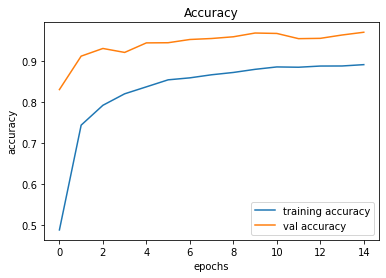

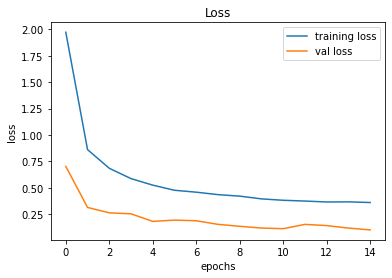

In [14]:
#Graphique de l'accuracy

plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()


# Validation du modèle sur le jeu de test

In [36]:
#prédiction sur l'ensemble de données de test

from sklearn.metrics import accuracy_score

y_test = pd.read_csv('Test.csv')
labels = y_test["ClassId"].values
imgs = y_test["Path"].values
data=[]

for img in imgs:
    image = Image.open(img)
    image = image.resize((30,30))
    data.append(np.array(image))

X_test=np.array(data)
pred=model.predict(X_test) 
classes=np.argmax(pred,axis=1)



395/395 [==============================] - 7s 17ms/step


In [37]:
print(classes)

[16  1 38 ...  8  7 10]


In [29]:
#Calcul de la précision (Accuracy) sur le jeu de test
from sklearn.metrics import accuracy_score
print ("Accuracy : ", round(accuracy_score(labels,classes)*100,43))

Accuracy :  92.71575613618369


# Enregistrer le modele.



In [31]:
model.save("traffic_classifier.h5")

# interface graphique détecteur de panneaux de signalisation

In [3]:
import tkinter as tk
from tkinter import filedialog
from tkinter import *
from PIL import ImageTk, Image

import numpy
#load the trained model to classify sign
from keras.models import load_model
model = load_model('traffic_classifier.h5')

#dictionary to label all traffic signs class.
classes = { 1:'limitation de vitesse (20km/h)',
            2:'limitation de vitesse (30km/h)', 
            3:'limitation de vitesse (50km/h)', 
            4:'limitation de vitesse (60km/h)', 
            5:'limitation de vitesse (70km/h)', 
            6:'limitation de vitesse (80km/h)', 
            7:'Fin de limitation de vitesse (80km/h)', 
            8:'limitation de vitesse (100km/h)', 
            9:'limitation de vitesse (120km/h)', 
            10:'Dépassement Interdit', 
            11:'Aucun véhicule passant de plus de 3,5 tonnes', 
            12:'Priorité ponctuelle', 
            13:'Route prioritaire', 
            14:'Cedez le passage', 
            15:'Stop', 
            16:'Circulation interdite', 
            17:'Interdit aux véhicules de plus de 3t', 
            18:'Sens interdit', 
            19:'Autres dangers', 
            20:'Virage à gauche', 
            21:'Virage à droite', 
            22:'Succession de virages', 
            23:'Dos âne', 
            24:'Chaussée glissante', 
            25:'Chaussée rétrécie par la droite', 
            26:'Travaux', 
            27:'Feux tricolores', 
            28:'Passage piétons', 
            29:'Lieu fréquenté par les enfants', 
            30:'Passage de cyclistes', 
            31:'Attention neige ou glace',
            32:'Passage animaux sauvages', 
            33:'Fin de limitation de vitesse', 
            34:'Obligation de tourner à droite', 
            35:'Obligation de tourner à gauche', 
            36:'Obligation aller tout droit', 
            37:'Aller tout droit ou à droite', 
            38:'Aller tout droit ou à gauche', 
            39:'Rester à droite', 
            40:'Rester à gauche', 
            41:'Rond point obligatoire', 
            42:'Fin interdiction de dépasser', 
            43:'Fin interdiction de dépasser pour les véhicules de plus de 3,5 tonnes' }


#initialise GUI
top=tk.Tk()
top.geometry('800x600')
top.title('Traffic sign classification')
top.configure(background='#CDCDCD')

label=Label(top,background='#CDCDCD', font=('arial',15,'bold'))
sign_image = Label(top)

def classify(file_path):
    global label_packed
    image = Image.open(file_path)
    image = image.resize((30,30))
    image = numpy.expand_dims(image, axis=0)
    image = numpy.array(image)
    pred = model.predict(image)
    cl=np.argmax(pred)
    print(cl)
    sign = classes[cl+1]
    print(sign)
    label.configure(foreground='#011638', text=sign) 

def show_classify_button(file_path):
    classify_b=Button(top,text="Classify Image",command=lambda: classify(file_path),padx=10,pady=5)
    classify_b.configure(background='#364156', foreground='white',font=('arial',10,'bold'))
    classify_b.place(relx=0.79,rely=0.46)

def upload_image():
    try:
        file_path=filedialog.askopenfilename()
        uploaded=Image.open(file_path)
        uploaded.thumbnail(((top.winfo_width()/2.25),(top.winfo_height()/2.25)))
        im=ImageTk.PhotoImage(uploaded)

        sign_image.configure(image=im)
        sign_image.image=im
        label.configure(text='')
        show_classify_button(file_path)
    except:
        pass

upload=Button(top,text="Upload an image",command=upload_image,padx=10,pady=5)
upload.configure(background='#364156', foreground='white',font=('arial',10,'bold'))

upload.pack(side=BOTTOM,pady=50)
sign_image.pack(side=BOTTOM,expand=True)
label.pack(side=BOTTOM,expand=True)
heading = Label(top, text="Know Your Traffic Sign",pady=20, font=('arial',20,'bold'))
heading.configure(background='#CDCDCD',foreground='#364156')
heading.pack()
top.mainloop()

1/1 [==============================] - 0s 141ms/step
1
limitation de vitesse (30km/h)
1/1 [==============================] - 0s 16ms/step
16
Interdit aux véhicules de plus de 3t
1/1 [==============================] - 0s 31ms/step
9
Dépassement Interdit
